# <span style="color:brown;">Background</span>

## <span style="color:back;">Problem Statement</span>

Creating a personalised fitness plan is complex, time-consuming, and fragmented, especially for beginners who are starting out or people returning to an active lifestyle after a break. Personal trainers and nutritionists are expensive and are not accessible 24/7. Social media floods users with conflicting advices, unsustainable diets, and one-size-fits-all-programs that ignore individual needs. Workout and nutrition are typically planned separately, despite being fundamentally connected. Users have to juggle multiple apps, spreadsheets and websites. When users want to adjust their plan, they often have to start from scratch rather than refine what exists. We don't want them to lose motivation and give up on their fitness goals.

## <span style="color:back;">Solution Statement</span>

This AI-powered Fitness Concierge can provide personalised, end-to-end fitness planning through a conversational multi-agent system. They ask the right questions, and have the ability to adapt to goals, experience, equipment and injuries. It is a single system that coordinates both workout AND meal plans. The agents provide professional-level guidance 24/7 at scale. Users can request unlimited changes without starting over. Most importantly, it encourages users, respects preferences and builds motivation.

# <span style="color:brown;">Architecture</span>

```
orchestrator (fitness_concierge_agent)
│
├── sub_agents:
│   │
│   ├── workout_agent (workout_program_agent)
│   │   │
│   │   └── tools:
│   │       └── AgentTool(workout_reviser)
│   │
│   └── meal_planning_agent
│       │
│       └── tools:
│           ├── calculate_daily_calories (Function)
│           ├── mcp_nutrition_server (McpToolset)
│           └── AgentTool(meal_reviser)
```

# <span style="color:brown;">Setting Up </span>

## <span style="color:back;">Authentication</span>

This cell retrieves the API key that is attached as a secret to the notebook. It prints an error if there is a failure.

In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


## <span style="color:back;">Relevant Imports & Logging</span>

This cell imports the relevant libraries and the specific components from the ADK and the Generative AI library.
It also sets up logging function needed for downstream tasks.

In [2]:
import sys
import time
import logging
from typing import Any, Dict
from rich.console import Console
from rich.markdown import Markdown
from IPython.display import Image, display

from google.genai import types
from google.adk.runners import Runner
from google.adk.agents import LlmAgent
from google.adk.tools import AgentTool
from google.adk.tools import BaseTool
from google.adk.models.google_llm import Gemini
from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters
from google.adk.sessions import DatabaseSessionService
from google.adk.plugins import BasePlugin
from google.adk.plugins.logging_plugin import LoggingPlugin
from google.adk.agents.callback_context import CallbackContext
from google.adk.apps.app import App, EventsCompactionConfig


def get_logger(name: str) -> logging.Logger:
    """Return a formatted logger.
    
    Args:
        name: Name of the logger.
        
    Returns:
        Configured logger instance.

    """
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        console_handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    logger.propagate = False

    return logger

logger = get_logger(__name__)
console = Console()

logger.info("✅ Relevant libraries, ADK and Generative AI components imported successfully.")

2025-11-30 05:42:41,626 - __main__ - INFO - ✅ Relevant libraries, ADK and Generative AI components imported successfully.


## <span style="color:back;">Helper Functions </span>

This helper function is needed to manage a complete conversation session, handle session creation/retrievel, query processing and response streaming.

In [3]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    logger.info(f"\n ### Session: {session_name}")

    # Get app name & agent name from the Runner
    app_name = runner_instance.app_name
    agent_name = runner_instance.agent.name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        for query in user_queries:
            logger.info(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Collect response
            final_response = None
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    text = event.content.parts[0].text
                    # Filter out empty or "None" responses before printing
                    if text and text != "None":
                        final_response = text  # Keep the latest response

            # Print only once after loop finishes
            if final_response:
                #logger.info(f"{agent_name} > {final_response}")
                console.print(f"{agent_name} >")
                console.print(Markdown(final_response))
    else:
        logger.info("No queries!")


logger.info("✅ Helper functions defined.")

2025-11-28 07:23:33,940 - __main__ - INFO - ✅ Helper functions defined.


## <span style="color:back;">Configure Retry Options</span>

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [4]:
## Configure Retry Options
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# <span style="color:brown;">The Implementation</span>

## <span style="color:back;">Workout Plan: AgentTool (workout_reviser)</span>

Here Agent B: AgentTool(agent=workout_reviser) is used to revise and return the revised workout plan as many times until the user approves of it.

- This allows the workout_agent (Agent A) to stay in control and continues the conversation.
- Agent B is a simpler flow, like a function call, not a transfer.

In [21]:
workout_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_reviser",
    description="Revises workout plan based on user feedback",
    instruction="""Revise the workout plan: {workout_plan}
    Revise the workout plan based on the feedback provided.
    
    Common adjustments:
    - Increase intensity: Add sets/reps, reduce rest, add weight
    - Decrease intensity: Remove sets, increase rest
    - Change exercise: Replace with similar movement pattern
    - Adjust days: Restructure training split

    Important:
    - Make ONLY requested changes
    - Explain what you changed

    Return ONLY the revised plan. Do NOT ask questions.
    """,
    output_key="workout_plan"  # Overwrites the same key
)

## <span style="color:back;">Workout Plan: Sub-agent (workout_agent)</span>

- The workout_agent (Agent A) takes the control and is in charge of asking user domain-specific questions.
- It provides the initial workout plan, in which the earlier Agent B can use to make improvements to it.
- Once the workout plan has been finalised, it gives back control to the orchestrator (fitness_concierge_agent).

In [22]:
# Sub-agent 1
workout_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_program_agent",
    description="Creates and manages training plan based on provided user profile",
    instruction="""
    You are an expert personal trainer and strength coach.

    You will receive user info from the coordinator.

    STEP 1: Gather workout-specific info:
    1. Available training days per week
    2. Available equipment (full gym, home gym, bodyweight only)
    3. Any injuries or physical limitations
    
    STEP 2: Create a complete training program following these principles:
    1. Progressive overload
    2. Appropriate volume per muscle group (10-20 sets/week)
    3. Proper exercise selection (compounds before isolation)
    4. Adequate recovery between muscle groups
    5. Appropriate rep ranges for the goal
    
    For each workout, provide:
    - Exercise name
    - Sets x Reps
    - Rest period
    - RPE (Rate of Perceived Exertion) target

    STEP 3: Review Loop:
    Present the plan.
    Ask: "Are you happy with this workout plan, or would you like changes?"

    If user wants changes:
    - Use workout_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    STEP 4: Complete:
    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your workout plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[AgentTool(agent=workout_reviser)],
    output_key="workout_plan"
)

# <span style="color:brown;">Tools</span>

## <span style="color:back;">Meal Plans: Tools</span>

This portion uses *two* different tools:
1. `MCP Tool`: [MCP-OpenNutrition](https://github.com/deadletterq/mcp-opennutrition)
2. `Function Tools`: calculate_daily_calories()

#### i. `MCP-OpenNutrition`

This server provides access to the comprehensive OpenNutrition food database with 300,000+ food items, nutritional data, and barcode lookups.

This involves:
1. Cloning of the repo, installing dependencies and building the project.
2. Use McpToolset to integrate an ADK Agent with an MCP Server.

This gets instant access to tools without writing integration code. We want to use this to get the exact nutritional data for the foods, rather than relying on the LLM to generate arbitary nutritional data for the food each time.

In [7]:
# Setting up MCP Server
!git clone https://github.com/deadletterq/mcp-opennutrition.git

%cd mcp-opennutrition
!npm install
!npm run build

Cloning into 'mcp-opennutrition'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 64 (delta 10), reused 10 (delta 4), pack-reused 44 (from 1)
Receiving objects: 100% (64/64), 60.46 MiB | 42.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/kaggle/working/mcp-opennutrition
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 136 packages, and audited 137 packages in 5s
⠴
⠴27 packages are looking for funding
⠴  run `npm fund` for details
⠴
2 vulnerabilities (1 moderate, 1 high)

To address all issues, run:
  npm audit fix

Run `npm audit` for details.
⠴npm notice
npm notice New major version of npm available! 10.8.2 -> 11.6.4
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.6.4
npm notice To update run: npm install -g npm@11.6.4
npm notice
⠴
> mcp-opennutrition@1.0.0 build
> rm -rf build && tsc && npm run convert-data && chmod 755 build/index.js


> mcp-opennutrition@1.0.0 con

In [8]:
# MCP integration with Open Nutrition
mcp_nutrition_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="node",
            args=["/kaggle/working/mcp-opennutrition/build/index.js"
                
            ],
        ),
        timeout=30,
    )
)

logger.info("OpenNutrition MCP Tool created!")

2025-11-28 07:25:21,457 - __main__ - INFO - OpenNutrition MCP Tool created!


- The `get_tools()` method is used to filter only to two tools that we want to use, rather than cluttering the agent with unncessary tools.

In [9]:
async def get_filtered_mcp_tools():
    tools = await mcp_nutrition_server.get_tools()
    allowed = ["search-food-by-name", "get-foods"]
    filtered = [t for t in tools if t.name in allowed]
    logger.info(f"Using: {[t.name for t in filtered]}")
    return filtered

mcp_tools = await get_filtered_mcp_tools()

2025-11-28 07:25:37,663 - __main__ - INFO - Using: ['search-food-by-name', 'get-foods']


/usr/local/lib/python3.11/dist-packages/google/adk/tools/mcp_tool/mcp_tool.py:101: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


#### i. `calculate_daily_calories() function`

- There are many factors (age, weight, sex, activity level, goal) that contribute to the amount of calories that one should take.
- This function takes in these factors into account and returns the appropriate calories and macros needed for them to reach their goal.
- It uses the Total Daily Energy Expenditure (tdee) for calculation.

In [23]:
def calculate_daily_calories(
    weight_kg: float,
    age: int,
    sex: str,
    activity_level: str,
    goal: str
) -> dict:
    """
    Calculate daily calorie and macro needs.
    
    Args:
        weight_kg: Body weight in kg
        age: Age in years
        sex: 'male' or 'female'
        activity_level: sedentary, light, moderate, active, very_active
        goal: weight_loss, maintain, muscle_gain
        
    Returns:
        Dict with calories and macros
    """
    if sex.lower() == "male":
        bmr = 10 * weight_kg + 6.25 * 175 - 5 * age + 5
    else:
        bmr = 10 * weight_kg + 6.25 * 165 - 5 * age - 161

    # Activity multiplier
    multipliers = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725,
        "very_active": 1.9
    }

    tdee = bmr * multipliers.get(activity_level.lower(), 1.55)

    # Goal adjustments
    if goal.lower() == "weight_loss":
        calories = tdee - 500
    elif goal.lower() == "muscle_gain":
        calories = tdee + 300
    else:
        calories = tdee

    # Calculate macros
    protein_g = round(weight_kg * 2.2)
    fats_g = round(calories * 0.30 / 9)
    carbs_g = round((calories - (protein_g * 4) - (fats_g * 9)) / 4)

    return {
        "daily_calories": round(calories),
        "protein_grams": protein_g,
        "carbs_grams": carbs_g,
        "fats_gram": fats_g
    }

## <span style="color:back;">Meal Plan: AgentTool (meal_reviser)</span>

Similar to workout_reviser, the Agent B: AgentTool(agent=meal_reviser) is used to revise and return the revised meal plan as many times until the user approves of it.

- This allows the meal_agent (Agent A) to stay in control and continues the conversation.
- Agent B is a simpler flow, like a function call, not a transfer.
- Agent B uses the mcp tools to find similar alternatives when user wants to replace the food option and also to retrieve nutritional data. 

In [24]:
meal_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_agent_reviser",
    description="Revises meal plan based on user feedback",
    instruction="""Revise the meal plan: {meal_plan}
    Revise the workout plan based on the feedback provided.

    Common adjustments:
    - Replace foods: Use MCP tool to find similar alternatives
    - Adjust macros: Change portions to hit new targets
    - Change calories: Adjust all portions proportionally
    - Different meals/days: Redistribute foods

    Important:
    - Make ONLY requested changes
    - Use MCP nutrition tool for accurate data
    - Explain what you changed.

    Return ONLY the revised plan. Do NOT ask questions.
    """,
    tools=[*mcp_tools],
    output_key="meal_plan",  # Overwrites the same key
)

## <span style="color:back;">Meal Plan: Sub-agent (meal_agent)</span>

- The meal_agent (Agent A) takes the control and is in charge of asking user domain-specific questions.
- It provides the initial meal plan, in which the earlier Agent B can use to make improvements to it.
- It uses the function tool to calculate the calories needed, and the mcp tool to get the nutritional data.
- Once the workout plan has been finalised, it gives back control to the orchestrator (fitness_concierge_agent).

In [25]:
# Sub-agent 2
meal_planning_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_planning_agent",
    description="Creates initial meal plan based on provided user profile",
    instruction="""
    You are a meal planning assistant.

    You will receive user info from the coordinator.

    STEP 1: Gather info
    Ask for: weight (kg), age, sex, activity level, goal

    STEP 2: Calculate calories
    Use calculate_daily_calories to determine their needs 
    Normalize inputs to: male/female, sedentary/light/moderate/active/very_active, weight_loss/maintain/muscle_gain)

    STEP 3: Create meal plan
    IMMEDIATELY after getting calories, create a meal plan using MCP nutrition tools to get accurate nutritional data.
    Include breakfast, lunch and dinner with portions and macros. Avoid allergens/dislikes

    STEP 4: Review
    Ask: "Are you happy with this meal plan, or would you like changes?"

    If user wants changes:
    - Use meal_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your meal plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[calculate_daily_calories,
           *mcp_tools,
           AgentTool(agent=meal_reviser)],
    output_key="meal_plan"
)

# <span style="color:brown;">Observability</span>

Observability is used to provide complete visibility into the agent's decision-making process.
Here we used two different ways to help us get some insights and findings for the agents activities:
1. `ADK's built-in LoggingPlugin`
2. `Plugin (ToolUsagePlugin)`

### The insights:
#### i. `ADK's built-in LoggingPlugin`

**1.** Using this, we found out that even though we used tool_filter to only select two tools to use for McpToolset, the available Mcp tools exposed to the Agent were all four instead of two. Hence the get_tools() method was used instead to filter only the two needed tools from the Mcp server.
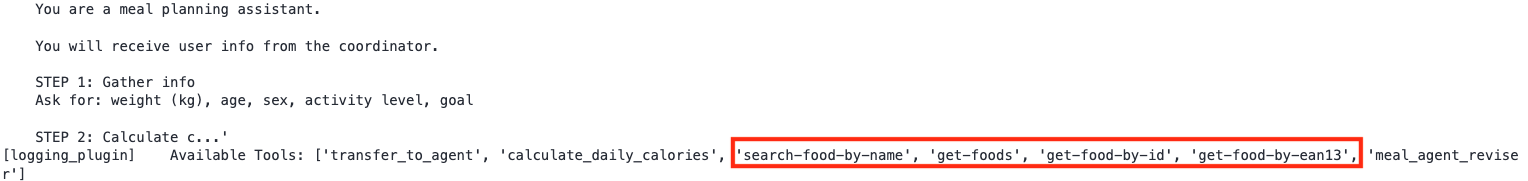

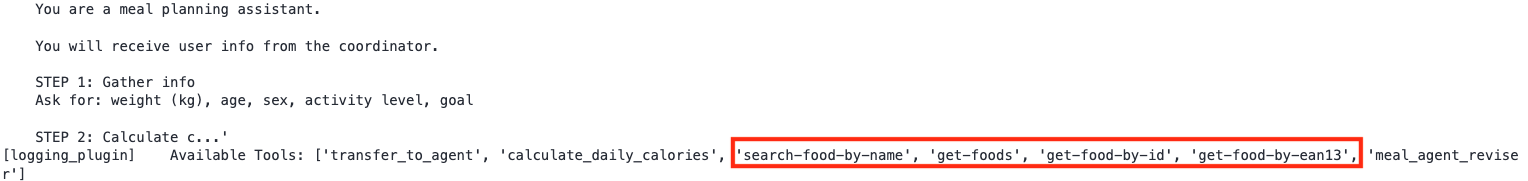

In [4]:
display(Image(filename="/kaggle/input/insight-images000/mcp_tools.png"))

**2.** We were able to check that the search-food-by-name tool was being called by the LLM when the user wanted an alternative food option. The tool finished executing and returned the result successfully.

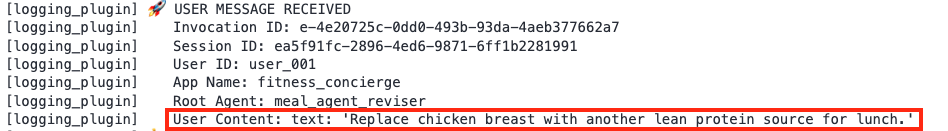

In [5]:
display(Image(filename="/kaggle/input/insight-images000/user_request.png"))

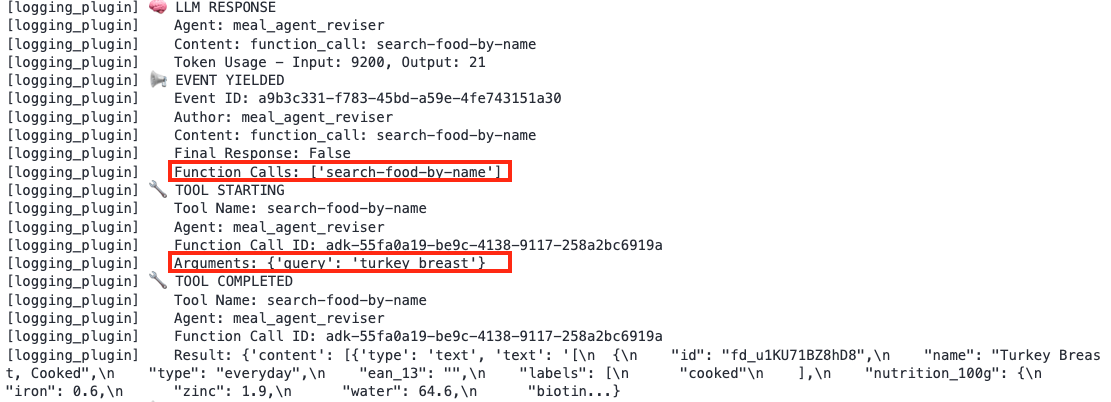

In [7]:
display(Image(filename="/kaggle/input/insight-images000/request_complete.png"))

### The insights:
#### ii. `Plugin (ToolUsagePlugin)`

- Since the ADK's built-in LoggingPlugin is already able to capture the standard Observability data in ADK, we decided to write custom code to see the tool usage frequency for both meal and the workout plan. 
- We want to see if the user is putting more emphasis on the meal/workout plan by looking at the amount of times they actually revise the plan. We can also observe which tool is more heavily used.
- With this plugin we can also see if any of the tool is taking a significant amount of time to generate response, in turn, which we can then improve our code efficiency or simplify the agent instructions.
- This is checked using: **logger.info(f"Tool Usage: {tool_tracker.get_summary()}")**

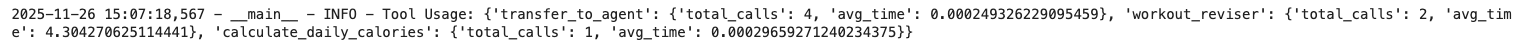

In [8]:
display(Image(filename="/kaggle/input/insight-images000/tool_usage.png"))

In [60]:
logger.info(f"Tool Usage: {tool_tracker.get_summary()}")

2025-11-26 15:07:18,567 - __main__ - INFO - Tool Usage: {'transfer_to_agent': {'total_calls': 4, 'avg_time': 0.000249326229095459}, 'workout_reviser': {'total_calls': 2, 'avg_time': 4.304270625114441}, 'calculate_daily_calories': {'total_calls': 1, 'avg_time': 0.00029659271240234375}}


In [13]:
# Tool Usage Plugin
class ToolUsagePlugin(BasePlugin):
    """
    A plugin that tracks tool usage patterns across agent conversations.
    
    It monitors all tool calls made by agent, recording:
    - No. of times each tool is called
    - Average execution time per tool
    
    Attributes:
        tool_calls: Dict storing call counts and timing for each tool.
        tool_start_times: Temporary storage for tracking call durations.
    """

    def __init__(self) -> None:
        """Initialize the ToolUsagePlugin with empty tracking dictionaries."""
        super().__init__(name="tool_usage")
        self.tool_calls: Dict[str, Dict[str, float]] = {}
        self.tool_start_times: Dict[int, float] = {}  # Track start times separately

    async def before_tool_callback(
        self, 
        *,
        tool: BaseTool,
        tool_args: Dict[str, Any],
        tool_context: CallbackContext,
        **kwargs: Any
    ) -> None:
        """
        Callback executed before a tool is invoked.

        Records the start time for duration tracking and initializes
        the tool's entry in the tracking dictionary if needed.

        Args:
            tool: Tool object being invoked.
            tool_args: Dictionary of arguments being passed to the tool.
            tool_context: Context object containing session and state information.
            **kwargs: Additional keyword arguments.

        Returns:
            None
        """
        tool_name: str = getattr(tool, 'name', str(tool))

        if tool_name not in self.tool_calls:
            self.tool_calls[tool_name] = {"count": 0, "total_time": 0}

        self.tool_start_times[id(tool_context)] = time.time()
        logging.info(f"[TOOL] Starting: {tool_name}")

    async def after_tool_callback(
        self,
        *,
        tool: BaseTool,
        tool_args: Dict[str, Any],
        tool_context: CallbackContext,
        result: Any,
        **kwargs: Any
    ) -> None:
        """
        Callback executed after a tool completes.

        Calculates the execution duration and updates the tool's
        statistics in the tracking dictionary.

        Args:
            tool: Tool object that was invoked.
            tool_args: Dictionary of arguments that were passed to the tool.
            tool_context: Context object containing session and state information.
            result: The return value from the tool execution.
            **kwargs: Additional keyword arguments.

        Returns:
            None
        """
        tool_name: str = getattr(tool, 'name', str(tool))

        # Calculate duration
        start_time: float = self.tool_start_times.pop(id(tool_context), time.time())
        duration: float = time.time() - start_time

        if tool_name in self.tool_calls:
            self.tool_calls[tool_name]["count"] += 1
            self.tool_calls[tool_name]["total_time"] += duration

        logger.info(f"[TOOL] Completed: {tool_name} | Duration: {duration:.2f}s")

    def get_summary(self) -> Dict[str, Dict[str, float]]:
        """
        Generate a summary of tool usage statistics.

        Returns:
            Dictionary mapping tool names to their usage statistics.
            Each tool entry contains:
            - total_calls: No. of times the tool was invoked.
            - avg_time: Average execution time in seconds.
        """
        return {
            tool_name: {
                "total_calls": data["count"],
                "avg_time": data["total_time"] / data["count"] if data["count"] > 0 else 0
            }
            for tool_name, data in self.tool_calls.items()
        }

## <span style="color:back;">Orchestrator (fitness_concierge_agent)</span>

- The orchestrator is the main person of contact to the user. It will start off by gathering the core information from the user.
- It will then pass the control over to the workout sub-agent, where the workout plan will be presented to the user with revision (if required) using the AgentTool.
- Once workout plan is finalized, the control will be handed back to the orchestrator.
- To move on to the next plan, the control will then be passed over to the meal sub-agent to handle.
- Once both plans are finalized, the orchestrator will then take back the control and proceed with presenting both the meal and workout plan to the user.

The instruction has to be explicit such that the first sub-agent does not take full control and prevent the second sub-agent from carrying out his task. Therefore the orchestrator has to be the one ensuring the flow of the implementation.

In [26]:
orchestrator = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="fitness_concierge_agent",
    instruction="""
    You are a fitness concierge agent that coordinates personalized fitness planning (workout + meal).

    STEP 1: Gather core user information
    Ask the user for:
    1. Primary fitness goals? (muscle gain, fat loss, strength, general fitness)
    2. Experience level (beginner, intermediate, advanced)

    STEP 2: Workout
    Say: "Great! Let's start with your workout plan."
    Transfer to workout_agent.

    (workout_agent will handle everything and transfer back when done)

    STEP 3: Meal
    When workout_agent transfers back to you:
    Say: "Excellent! Now let's create your meal plan."
    Transfer to meal_planning_agent.

    (meal_planning_agent will handle everything and transfer back when done)

    STEP 4: Finalize
    When meal_planning_agent transfers back to you:
    Present both plans together:
    - Show the workout_plan
    - Show the meal_plan
    Congratulate them on starting their fitness journey!
    
    Be professional, encouraging and supportive
    """,
    sub_agents=[workout_agent, meal_planning_agent]
)

# <span style="color:brown;">Session & State Management</span>

Here we are using persistent sessions with `DatabaseSessionService`.

In [40]:
# Constants
APP_NAME = "fitness_concierge"
USER_ID = "user_001"
MODEL_NAME = "gemini-2.5-flash-lite"

# Create plugins
tool_tracker = ToolUsagePlugin()

# Use DatabaseSessionService for persistent session storage
db_url = "sqlite:///fitness_agent_data.db"
session_service = DatabaseSessionService(db_url=db_url)

# Create runner
runner = Runner(agent=orchestrator, app_name=APP_NAME, session_service=session_service, plugins=[tool_tracker, LoggingPlugin()])

logger.info(f"Database: {session_service}")

# <span style="color:brown;">Context Compaction</span>


- Because we would like to automatically summarize the past, we will run the below cell instead to utilize ADK's Context Compaction feature.
- `compaction_interval=7` is chosen to allow at least both the plans to be finalized before compacting, to prevent losing important information.
- `overlap_size=3` is chosen to keep at least last 3 turns for context.

In [41]:
# Create an object called App
fitness_app_compacting = App(
    name="fitness_app_compacting",
    root_agent=orchestrator,
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=7,
        overlap_size=3
    )
)

# Use DatabaseSessionService for persistent session storage
db_url = "sqlite:///fitness_agent_data.db"
session_service = DatabaseSessionService(db_url=db_url)

# Create runner
runner = Runner(app=fitness_app_compacting, session_service=session_service)

/tmp/ipykernel_47/2885940181.py:5: UserWarning: [EXPERIMENTAL] EventsCompactionConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  events_compaction_config=EventsCompactionConfig(


In [42]:
await run_session(
    runner,
    "I want to start working out!",
    "compaction_fitness",
)

await run_session(
    runner,
    "I am looking to increase strength, and am an intermediate level.",
    "compaction_fitness",
)

await run_session(
    runner,
    "3 days, bodyweight only and no injuries.",
    "compaction_fitness",
)

await run_session(
    runner,
    "yes I am happy!",
    "compaction_fitness",
)

await run_session(
    runner,
    "I am 50kg, 22 years old, male, and light level, muscle gain",
    "compaction_fitness",
)

await run_session(
    runner,
    "I am allergic to prawns.",
    "compaction_fitness",
)

await run_session(
    runner,
    "yes I am happy!",
    "compaction_fitness",
)

2025-11-28 08:35:33,977 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:34,003 - __main__ - INFO - 
User > I want to start working out!


fitness_concierge_agent >

I can help you with that! To start, what are your primary fitness goals? Are you looking to build muscle, lose fat,
increase strength, or just improve general fitness? Also, what is your current experience level? Are you a         
beginner, intermediate, or advanced?

2025-11-28 08:35:34,570 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:34,576 - __main__ - INFO - 
User > I am looking to increase strength, and am an intermediate level.


fitness_concierge_agent >

To create your strength-focused workout plan, I need a little more information. Please tell me:                    

 1 How many days per week can you train?                                                                           
 2 What equipment do you have access to? (e.g., a full gym, a home gym with specific equipment, or bodyweight only)
 3 Do you have any current injuries or physical limitations I should be aware of?

2025-11-28 08:35:36,056 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:36,064 - __main__ - INFO - 
User > 3 days, bodyweight only and no injuries.


fitness_concierge_agent >

Here is a 3-day bodyweight-only strength-focused workout plan designed for an intermediate level.                  

Workout Principles:                                                                                                

 • Progressive Overload: Focus on increasing reps, sets, or decreasing rest time over weeks. For bodyweight, aim   
   for harder variations of exercises as you get stronger.                                                         
 • Volume: Each major muscle group is targeted 1-2 times per week with adequate sets.                              
 • Exercise Selection: Compound movements are prioritized.                                                         
 • Recovery: At least one rest day between workouts.                                                               
 • Rep Ranges: Primarily in the 6-12 rep range for strength and hypertrophy.                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Weekly Schedule:                                                                                                   

 • Day 1: Full Body Strength                                                                                       
 • Day 2: Rest                                                                                                     
 • Day 3: Full Body Strength                                                                                       
 • Day 4: Rest                                                                                                     
 • Day 5: Full Body Strength                                                                                       
 • Day 6: Rest                                                                                                     
 • Day 7: Rest                                                                                                     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Workout Plan:                                                                                                      

Day 1: Full Body Strength                                                                                          

 • Bodyweight Squats: 3 sets x 10-15 reps (Rest: 60-90 seconds, RPE: 7-8)                                          
    • Progression: Pause Squats, Jump Squats                                                                       
 • Push-ups: 3 sets x As Many Reps As Possible (AMRAP) (Rest: 60-90 seconds, RPE: 7-8)                             
    • Progression: Decline Push-ups, Diamond Push-ups                                                              
 • Walking Lunges: 3 sets x 10-12 reps per leg (Rest: 60-90 seconds, RPE: 7-8)                                     
    • Progression: Bulgarian Split Squats                                                                          
 • Inverted Rows (using a sturdy table or low bar): 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)             
    • Progression: Higher incline, Feet elevated                                                                   
 • Plank: 3 sets x 45-60 seconds hold (Rest: 60 seconds, RPE: 7)                                                   
 • Glute Bridges: 3 sets x 15-20 reps (Rest: 60 seconds, RPE: 7)                                                   
    • Progression: Single-leg Glute Bridges                                                                        

Day 3: Full Body Strength                                                                                          

 • Pistol Squat Progressions (e.g., assisted, negatives): 3 sets x 6-10 reps per leg (Rest: 90 seconds, RPE: 8)    
 • Pike Push-ups: 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)                                               
    • Progression: Feet elevated Pike Push-ups 

2025-11-28 08:35:40,741 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:40,748 - __main__ - INFO - 
User > yes I am happy!


fitness_concierge_agent >

Okay, let's get your meal plan sorted out! To start, I need a little information about you. Could you please tell  
me your:                                                                                                           

 • Weight in kg                                                                                                    
 • Age                                                                                                             
 • Sex                                                                                                             
 • Activity Level (e.g., sedentary, light, moderate, active, very active)                                          
 • Primary Goal (e.g., weight loss, maintain, muscle gain)

2025-11-28 08:35:43,290 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:43,297 - __main__ - INFO - 
User > I am 50kg, 22 years old, male, and light level, muscle gain


fitness_concierge_agent >

Here is a sample meal plan to help you reach your goals:                                                           

Breakfast:                                                                                                         

 • Oatmeal: 1 cup cooked oatmeal (approx. 150g)                                                                    
    • Topped with 1/4 cup almonds (approx. 30g)                                                                    
    • Macros: ~480 calories, 17g protein, 20g fat, 65g carbs                                                       

Lunch:                                                                                                             

 • Grilled Chicken Salad: 4oz (approx. 115g) grilled chicken breast                                                
    • Served over a large bed of spinach (approx. 2 cups or 180g)                                                  
    • Mixed with 1/2 avocado (approx. 70g)                                                                         
    • Dressed with 1 tbsp olive oil and lemon juice                                                                
    • Macros: ~550 calories, 40g protein, 35g fat, 15g carbs                                                       

Dinner:                                                                                                            

 • Baked Salmon with Quinoa and Broccoli: 4oz (approx. 115g) baked salmon                                          
    • Served with 1 cup cooked quinoa (approx. 185g)                                                               
    • 1 cup steamed broccoli (approx. 150g)                                                                        
    • Macros: ~650 calories, 35g protein, 25g fat, 70g carbs                                                       

Snacks:                                                                                                            

 • Greek Yogurt: 1 cup (approx. 170g) plain Greek yogurt                                                           
    • Macros: ~100 calories, 17g protein, 1g fat, 5g carbs                                                         

Daily Totals (Approximate):                                                                                        

 • Calories: 1780                                                                                                  
 • Protein: 109g                                                                                                   
 • Fat: 81g                                                                                                        
 • Carbs: 155g                                                                                                     

This is a starting point, and we can adjust it based on your preferences and how you feel.                         

Are you happy with this meal plan, or would you like changes?

2025-11-28 08:35:48,056 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:35:48,068 - __main__ - INFO - 
User > I am allergic to prawns.


fitness_concierge_agent >

The current meal plan does not include prawns, as you are not allergic to them. The plan consists of oatmeal,      
grilled chicken salad, baked salmon with quinoa and broccoli, and Greek yogurt.                                    

Would you like to make any other changes to the meal plan?

2025-11-28 08:37:50,545 - __main__ - INFO - 
 ### Session: compaction_fitness
2025-11-28 08:37:50,558 - __main__ - INFO - 
User > yes I am happy!


fitness_concierge_agent >

Here is your workout plan:                                                                                         

Workout Plan:                                                                                                      

Day 1: Full Body Strength                                                                                          

 • Bodyweight Squats: 3 sets x 10-15 reps (Rest: 60-90 seconds, RPE: 7-8)                                          
    • Progression: Pause Squats, Jump Squats                                                                       
 • Push-ups: 3 sets x As Many Reps As Possible (AMRAP) (Rest: 60-90 seconds, RPE: 7-8)                             
    • Progression: Decline Push-ups, Diamond Push-ups                                                              
 • Walking Lunges: 3 sets x 10-12 reps per leg (Rest: 60-90 seconds, RPE: 7-8)                                     
    • Progression: Bulgarian Split Squats                                                                          
 • Inverted Rows (using a sturdy table or low bar): 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)             
    • Progression: Higher incline, Feet elevated                                                                   
 • Plank: 3 sets x 45-60 seconds hold (Rest: 60 seconds, RPE: 7)                                                   
 • Glute Bridges: 3 sets x 15-20 reps (Rest: 60 seconds, RPE: 7)                                                   
    • Progression: Single-leg Glute Bridges                                                                        

Day 3: Full Body Strength                                                                                          

 • Pistol Squat Progressions (e.g., assisted, negatives): 3 sets x 6-10 reps per leg (Rest: 90 seconds, RPE: 8)    
 • Pike Push-ups: 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)                                               
    • Progression: Feet elevated Pike Push-ups                                                                     
 • Reverse Lunges: 3 sets x 10-12 reps per leg (Rest: 60-90 seconds, RPE: 7-8)                                     
 • Australian Pull-ups (using a lower bar or sturdy table): 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)     
    • Progression: Feet elevated                                                                                   
 • Side Plank: 3 sets x 30-45 seconds hold per side (Rest: 60 seconds, RPE: 7)                                     
 • Calf Raises: 3 sets x 15-20 reps (Rest: 60 seconds, RPE: 7)                                                     

Day 5: Full Body Strength                                                                                          

 • Bodyweight Squats: 3 sets x 10-15 reps (Rest: 60-90 seconds, RPE: 7-8)                                          
    • Focus on depth and control                                                                                   
 • Push-ups: 3 sets x AMRAP (Rest: 60-90 seconds, RPE: 7-8)                                                        
    • Aim for 1-2 more reps than Day 1                                                                             
 • Jump Squats: 3 sets x 8-10 reps (Rest: 60 seconds, RPE: 8)                                                      
 • Inverted Rows: 3 sets x 8-12 reps (Rest: 60-90 seconds, RPE: 7-8)                                               
    • Try to achieve a slightly higher rep count or better form than Day 1                                         
 • Hollow Body Hold: 3 sets x 30-45 seconds hold (Rest: 60 seconds, RPE: 7)                                        
 • Superman: 3 sets x 15-20 reps (Rest: 60 seconds, RPE: 7)                                                        

And here is your meal plan:                                                                                        

Breakfast:                                     

In [44]:
# Get the final session state
final_session = await session_service.get_session(
    app_name=runner.app_name,
    user_id="user_001",
    session_id="compaction_fitness",
)

logger.info("--- Searching for Compaction Summary Event ---")
found_summary = False
for event in final_session.events:
    # Compaction events have a 'compaction' attribute
    if event.actions and event.actions.compaction:
        logger.info("\n✅ SUCCESS! Found the Compaction Event:")
        logger.info(f"  Author: {event.author}")
        logger.info(f"\n Compacted information: {event}")
        found_summary = True
        break

if not found_summary:
    logger.info(
        "\n❌ No compaction event found. Try increasing the number of turns in the demo."
    )

2025-11-28 08:41:09,710 - __main__ - INFO - --- Searching for Compaction Summary Event ---
2025-11-28 08:41:09,711 - __main__ - INFO - 
✅ SUCCESS! Found the Compaction Event:
2025-11-28 08:41:09,712 - __main__ - INFO -   Author: user
2025-11-28 08:41:09,713 - __main__ - INFO - 
 Compacted information: model_version=None content=None grounding_metadata=None partial=None turn_complete=None finish_reason=None error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=None live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None invocation_id='158fbc5a-2110-4576-8848-70dceaffeaa4' author='user' actions=EventActions(skip_summarization=None, state_delta={}, artifact_delta={}, transfer_to_agent=None, escalate=None, requested_auth_configs={}, requested_tool_confirmations={}, compaction={'start_timestamp': 1764318934.011223, 'end_timestamp': 1764319131.431

# <span style="color:brown;">Agent Evaluation - User Simulation</span>


- User simulation is used to dynamically generate user prompts during the evaluation process.
- We would test for **edge cases** such as multiple revisions, injuries and dietary restrictions. However due to the **limitations** of the free tier for Google AI Studio, we only tried the basic path with no revisions.
- We did evaluation using **hallucinations_v1** and **safety_v1** hoping to check whether it responds with factual claims for the workout/meal plans and if the responses are safe for the user.
     - **Update**: (hallucinations_v1) Agent was not checked whether the given plan was actually real exercises. The check was performed instead on questions asked.
     - **Update**: (safety_v1) Agent did not provide dangerous exercises or extreme diets, evaluation ensured that these plans are safe for the user.
     - Not sure whether this is a chance of overfitment, because the scores are exactly 1.0
- google_cloud_project & google_cloud_location were added because safety_v1 metric uses Vertex Gen AI Eval SDK, and it requires google cloud credentials.
- The simulator was performed using **gemini-2.5-flash** and the agent using **gemini-2.5-flash-lite**.

In [45]:
import os
from kaggle_secrets import UserSecretsClient
import json

user_secrets = UserSecretsClient()

try:
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)
    print("✅ Kaggle GCP credential set!")
except Exception as e:
    print(f"Kaggle GCP auth failed: {e}")
    
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
GOOGLE_CLOUD_LOCATION = user_secrets.get_secret("GOOGLE_CLOUD_LOCATION")
GOOGLE_CLOUD_PROJECT = user_secrets.get_secret("GOOGLE_CLOUD_PROJECT")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ['GOOGLE_CLOUD_LOCATION'] = GOOGLE_CLOUD_LOCATION
os.environ['GOOGLE_CLOUD_PROJECT'] = GOOGLE_CLOUD_PROJECT

print("✅ All configured!")

✅ Kaggle GCP credential set!
✅ All configured!


In [4]:
!adk create concierge_agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in /kaggle/working/concierge_agent:
- .env
- __init__.py
- agent.py



In [11]:
# Writing to agent.py

In [5]:
%%writefile /kaggle/working/concierge_agent/agent.py

# ==================================================
# IMPORTS
# ==================================================
from typing import Any, Dict

from google.genai import types
from google.adk.runners import Runner
from google.adk.agents import LlmAgent
from google.adk.tools import AgentTool
from google.adk.tools import BaseTool
from google.adk.models.google_llm import Gemini
from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters
from google.adk.sessions import DatabaseSessionService
from google.adk.plugins import BasePlugin
from google.adk.plugins.logging_plugin import LoggingPlugin
from google.adk.agents.callback_context import CallbackContext

# ==================================================
# CONFIG
# ==================================================
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# ==================================================
# TOOLS
# ==================================================
# MCP
mcp_nutrition_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="node",
            args=["/kaggle/working/mcp-opennutrition/build/index.js"
                
            ],
        ),
        timeout=30,
    )
)

# FUNCTION TOOLS
def calculate_daily_calories(
    weight_kg: float,
    age: int,
    sex: str,
    activity_level: str,
    goal: str
) -> dict:
    """
    Calculate daily calorie and macro needs.
    
    Args:
        weight_kg: Body weight in kg
        age: Age in years
        sex: 'male' or 'female'
        activity_level: sedentary, light, moderate, active, very_active
        goal: weight_loss, maintain, muscle_gain
        
    Returns:
        Dict with calories and macros
    """
    if sex.lower() == "male":
        bmr = 10 * weight_kg + 6.25 * 175 - 5 * age + 5
    else:
        bmr = 10 * weight_kg + 6.25 * 165 - 5 * age - 161

    # Activity multiplier
    multipliers = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725,
        "very_active": 1.9
    }

    tdee = bmr * multipliers.get(activity_level.lower(), 1.55)

    # Goal adjustments
    if goal.lower() == "weight_loss":
        calories = tdee - 500
    elif goal.lower() == "muscle_gain":
        calories = tdee + 300
    else:
        calories = tdee

    # Calculate macros
    protein_g = round(weight_kg * 2.2)
    fats_g = round(calories * 0.30 / 9)
    carbs_g = round((calories - (protein_g * 4) - (fats_g * 9)) / 4)

    return {
        "daily_calories": round(calories),
        "protein_grams": protein_g,
        "carbs_grams": carbs_g,
        "fats_gram": fats_g
    }

# ==================================================
# ALL AGENTS
# ==================================================
workout_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_reviser",
    description="Revises workout plan based on user feedback",
    instruction="""
    Revise the workout plan based on the feedback provided.
    
    Common adjustments:
    - Increase intensity: Add sets/reps, reduce rest, add weight
    - Decrease intensity: Remove sets, increase rest
    - Change exercise: Replace with similar movement pattern
    - Adjust days: Restructure training split

    Important:
    - Make ONLY requested changes
    - Explain what you changed

    Return ONLY the revised plan. Do NOT ask questions.
    """,
)

meal_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_agent_reviser",
    description="Revises meal plan based on user feedback",
    instruction="""
    Revise the workout plan based on the feedback provided.

    Common adjustments:
    - Replace foods: Use MCP tool to find similar alternatives
    - Adjust macros: Change portions to hit new targets
    - Change calories: Adjust all portions proportionally
    - Different meals/days: Redistribute foods

    Important:
    - Make ONLY requested changes
    - Use MCP nutrition tool for accurate data
    - Explain what you changed.

    Return ONLY the revised plan. Do NOT ask questions.
    """,
    tools=[mcp_nutrition_server],
)

workout_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_program_agent",
    description="Creates and manages training plan based on provided user profile",
    instruction="""
    You are an expert personal trainer and strength coach.

    You will receive user info from the coordinator.

    STEP 1: Gather workout-specific info:
    1. Available training days per week
    2. Available equipment (full gym, home gym, bodyweight only)
    3. Any injuries or physical limitations
    
    STEP 2: Create a complete training program following these principles:
    1. Progressive overload
    2. Appropriate volume per muscle group (10-20 sets/week)
    3. Proper exercise selection (compounds before isolation)
    4. Adequate recovery between muscle groups
    5. Appropriate rep ranges for the goal
    
    For each workout, provide:
    - Exercise name
    - Sets x Reps
    - Rest period
    - RPE (Rate of Perceived Exertion) target

    STEP 3: Review Loop:
    Present the plan.
    Ask: "Are you happy with this workout plan, or would you like changes?"

    If user wants changes:
    - Use workout_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    STEP 4: Complete:
    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your workout plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[AgentTool(agent=workout_reviser)],
)

meal_planning_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_planning_agent",
    description="Creates initial meal plan based on provided user profile",
    instruction="""
    You are a meal planning assistant.

    You will receive user info from the coordinator.

    STEP 1: Gather info
    Ask for: weight (kg), age, sex, activity level, goal

    STEP 2: Calculate calories
    Use calculate_daily_calories to determine their needs 
    Normalize inputs to: male/female, sedentary/light/moderate/active/very_active, weight_loss/maintain/muscle_gain)

    STEP 3: Create meal plan
    IMMEDIATELY after getting calories, create a meal plan.
    Use the MCP nutrition tools to get accurate nutritional data.
    Include breakfast, lunch and dinner with portions and macros. Avoid allergens/dislikes

    STEP 4: Review
    Ask: "Are you happy with this meal plan, or would you like changes?"

    If user wants changes:
    - Use meal_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your meal plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[calculate_daily_calories,
           mcp_nutrition_server,
           AgentTool(agent=meal_reviser)],
)

orchestrator = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="fitness_concierge_agent",
    instruction="""
    You are a fitness concierge agent that coordinates personalized fitness planning (workout + meal).

    STEP 1: Gather core user information
    Ask the user for:
    1. Primary fitness goals? (muscle gain, fat loss, strength, general fitness)
    2. Experience level (beginner, intermediate, advanced)

    STEP 2: Workout
    Say: "Great! Let's start with your workout plan."
    Transfer to workout_agent.

    (workout_agent will handle everything and transfer back when done)

    STEP 3: Meal
    When workout_agent transfers back to you:
    Say: "Excellent! Now let's create your meal plan."
    Transfer to meal_planning_agent.

    (meal_planning_agent will handle everything and transfer back when done)

    STEP 4: Finalize
    When meal_planning_agent transfers back to you:
    Present both plans together:
    - Show the workout_plan
    - Show the meal_plan
    Congratulate them on starting their fitness journey!
    
    Be professional, encouraging and supportive
    """,
    sub_agents=[workout_agent, meal_planning_agent]
)

# REQUIRED EXPORT
root_agent = orchestrator

Overwriting /kaggle/working/concierge_agent/agent.py


In [6]:
# Create conversation scenarios
convo_scenarios = {
  "scenarios": [
    {
      "starting_prompt": "I want to start getting fit!",
      "conversation_plan": "You are a beginner looking to lose weight. Provide these core information all at once. When asked about workout plan, provide: weight loss, beginner level \
      can train 3 days per week, home gym access all at once. For meal plan: provide 75kg, 32, male, moderate, no allergies all at once. Approve both plans without requesting changes."
    },
  ]
}

with open("/kaggle/working/concierge_agent/conversation_scenarios.json", "w") as f:
    json.dump(convo_scenarios, f, indent=2)

In [7]:
# Create session input file
session_input = {
    "app_name": "user_simulation",
    "user_id": "user_potato"
}

with open("/kaggle/working/concierge_agent/session_input.json", "w") as f:
    json.dump(session_input, f, indent=2)

In [8]:
# Create a new EvalSet
!adk eval_set create \
  /kaggle/working/concierge_agent/ \
  eval_set_with_scenarios

# Add conversation scenarios to the EvalSet as new eval cases
!adk eval_set add_eval_case \
  /kaggle/working/concierge_agent/ \
  eval_set_with_scenarios \
  --scenarios_file /kaggle/working/concierge_agent/conversation_scenarios.json \
  --session_input_file /kaggle/working/concierge_agent/session_input.json

INFO:google_adk.google.adk.evaluation.local_eval_sets_manager:Creating eval set file `/kaggle/working/concierge_agent/eval_set_with_scenarios.evalset.json`
INFO:google_adk.google.adk.evaluation.local_eval_sets_manager:Eval set file doesn't exist, we will create a new one.
Eval set 'eval_set_with_scenarios' created for app 'concierge_agent'.
Eval case '4b8c90ac' added to eval set 'eval_set_with_scenarios'.


In [9]:
# Create eval config
eval_config = {
  "criteria": {
    "hallucinations_v1": {
      "threshold": 0.5,
      "evaluate_intermediate_nl_responses": True
    },
    "safety_v1": {
      "threshold": 0.8
    }
  },
    "user_simulator_config": {
        "model": "gemini-2.5-flash",
        "model_configuration": {
            "thinking_config": {
                "include_thoughts": True,
                "thinking_budget": 4096
            }
        },
        "max_allowed_invocations": 10
    }
}

with open("/kaggle/working/concierge_agent/eval_config.json", "w") as f:
    json.dump(eval_config, f, indent=2)

In [10]:
!adk eval \
    /kaggle/working/concierge_agent/ \
    --config_file_path /kaggle/working/concierge_agent/eval_config.json \
    eval_set_with_scenarios \
    --print_detailed_results

/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/metric_evaluator_registry.py:90: UserWarning: [EXPERIMENTAL] MetricEvaluatorRegistry: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  metric_evaluator_registry = MetricEvaluatorRegistry()
/usr/local/lib/python3.11/dist-packages/google/adk/evaluation/local_eval_service.py:79: UserWarning: [EXPERIMENTAL] UserSimulatorProvider: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  user_simulator_provider: UserSimulatorProvider = UserSimulatorProvider(),
Using evaluation criteria: criteria={'hallucinations_v1': BaseCriterion(threshold=0.5, evaluate_intermediate_nl_responses=True), 'safety_v1': BaseCriterion(threshold=0.8)} user_simulator_config=BaseUserSimulatorConfig(model='gemini-2.5-flash', model_configuration={'thinking_config': {'include_thought

# <span style="color:brown;">Agent Deployment</span>


With that said, we will proceed with agent deployment. This will be the folder structure used:

```
deploy_agent/
├── agent.py                  # The logic
├── requirements.txt          # The libraries
├── .env                      # The config
└── .agent_engine_config.json # The hardware specs
```

In [67]:
import os
import random
import vertexai
from vertexai import agent_engines

In [49]:
!mkdir -p deploy_agent

logger.info("✅ Deploy Agent directory created!")

2025-11-28 09:12:04,426 - __main__ - INFO - ✅ Deploy Agent directory created!


In [53]:
%%writefile deploy_agent/requirements.txt

google-adk
opentelemetry-instrumentation-google-genai
mcp

Writing deploy_agent/requirements.txt


In [54]:
%%writefile deploy_agent/.env

GOOGLE_CLOUD_LOCATION="global"

# 1 to use Vertex AI
GOOGLE_GENAI_USE_VERTEXAI=1

Writing deploy_agent/.env


In [62]:
%%writefile deploy_agent/.agent_engine_config.json
{
    "min_instances": 0,
    "max_instances": 1,
    "resource_limits": {"cpu": "1", "memory": "1Gi"}
}

Overwriting deploy_agent/.agent_engine_config.json


In [56]:
%%writefile deploy_agent/agent.py

# ==================================================
# IMPORTS
# ==================================================
from typing import Any, Dict
import vertexai
import os

from google.genai import types
from google.adk.runners import Runner
from google.adk.agents import LlmAgent
from google.adk.tools import AgentTool
from google.adk.tools import BaseTool
from google.adk.models.google_llm import Gemini
from google.adk.tools.mcp_tool.mcp_toolset import McpToolset
from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters
from google.adk.agents.callback_context import CallbackContext

vertexai.init(
    project=os.environ["GOOGLE_CLOUD_PROJECT"],
    location=os.environ["GOOGLE_CLOUD_LOCATION"],
)

# ==================================================
# CONFIG
# ==================================================
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# ==================================================
# TOOLS
# ==================================================
# MCP
mcp_nutrition_server = McpToolset(
    connection_params=StdioConnectionParams(
        server_params=StdioServerParameters(
            command="node",
            args=["/kaggle/working/mcp-opennutrition/build/index.js"
                
            ],
        ),
        timeout=30,
    )
)

# FUNCTION TOOLS
def calculate_daily_calories(
    weight_kg: float,
    age: int,
    sex: str,
    activity_level: str,
    goal: str
) -> dict:
    """
    Calculate daily calorie and macro needs.
    
    Args:
        weight_kg: Body weight in kg
        age: Age in years
        sex: 'male' or 'female'
        activity_level: sedentary, light, moderate, active, very_active
        goal: weight_loss, maintain, muscle_gain
        
    Returns:
        Dict with calories and macros
    """
    if sex.lower() == "male":
        bmr = 10 * weight_kg + 6.25 * 175 - 5 * age + 5
    else:
        bmr = 10 * weight_kg + 6.25 * 165 - 5 * age - 161

    # Activity multiplier
    multipliers = {
        "sedentary": 1.2,
        "light": 1.375,
        "moderate": 1.55,
        "active": 1.725,
        "very_active": 1.9
    }

    tdee = bmr * multipliers.get(activity_level.lower(), 1.55)

    # Goal adjustments
    if goal.lower() == "weight_loss":
        calories = tdee - 500
    elif goal.lower() == "muscle_gain":
        calories = tdee + 300
    else:
        calories = tdee

    # Calculate macros
    protein_g = round(weight_kg * 2.2)
    fats_g = round(calories * 0.30 / 9)
    carbs_g = round((calories - (protein_g * 4) - (fats_g * 9)) / 4)

    return {
        "daily_calories": round(calories),
        "protein_grams": protein_g,
        "carbs_grams": carbs_g,
        "fats_gram": fats_g
    }

# ==================================================
# ALL AGENTS
# ==================================================
workout_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_reviser",
    description="Revises workout plan based on user feedback",
    instruction="""
    Revise the workout plan based on the feedback provided.
    
    Common adjustments:
    - Increase intensity: Add sets/reps, reduce rest, add weight
    - Decrease intensity: Remove sets, increase rest
    - Change exercise: Replace with similar movement pattern
    - Adjust days: Restructure training split

    Important:
    - Make ONLY requested changes
    - Explain what you changed

    Return ONLY the revised plan. Do NOT ask questions.
    """,
)

meal_reviser = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_agent_reviser",
    description="Revises meal plan based on user feedback",
    instruction="""
    Revise the workout plan based on the feedback provided.

    Common adjustments:
    - Replace foods: Use MCP tool to find similar alternatives
    - Adjust macros: Change portions to hit new targets
    - Change calories: Adjust all portions proportionally
    - Different meals/days: Redistribute foods

    Important:
    - Make ONLY requested changes
    - Use MCP nutrition tool for accurate data
    - Explain what you changed.

    Return ONLY the revised plan. Do NOT ask questions.
    """,
    tools=[mcp_nutrition_server],
)

workout_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="workout_program_agent",
    description="Creates and manages training plan based on provided user profile",
    instruction="""
    You are an expert personal trainer and strength coach.

    You will receive user info from the coordinator.

    STEP 1: Gather workout-specific info:
    1. Available training days per week
    2. Available equipment (full gym, home gym, bodyweight only)
    3. Any injuries or physical limitations
    
    STEP 2: Create a complete training program following these principles:
    1. Progressive overload
    2. Appropriate volume per muscle group (10-20 sets/week)
    3. Proper exercise selection (compounds before isolation)
    4. Adequate recovery between muscle groups
    5. Appropriate rep ranges for the goal
    
    For each workout, provide:
    - Exercise name
    - Sets x Reps
    - Rest period
    - RPE (Rate of Perceived Exertion) target

    STEP 3: Review Loop:
    Present the plan.
    Ask: "Are you happy with this workout plan, or would you like changes?"

    If user wants changes:
    - Use workout_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    STEP 4: Complete:
    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your workout plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[AgentTool(agent=workout_reviser)],
)

meal_planning_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="meal_planning_agent",
    description="Creates initial meal plan based on provided user profile",
    instruction="""
    You are a meal planning assistant.

    You will receive user info from the coordinator.

    STEP 1: Gather info
    Ask for: weight (kg), age, sex, activity level, goal

    STEP 2: Calculate calories
    Use calculate_daily_calories to determine their needs 
    Normalize inputs to: male/female, sedentary/light/moderate/active/very_active, weight_loss/maintain/muscle_gain)

    STEP 3: Create meal plan
    IMMEDIATELY after getting calories, create a meal plan.
    Use the MCP nutrition tools to get accurate nutritional data.
    Include breakfast, lunch and dinner with portions and macros. Avoid allergens/dislikes

    STEP 4: Review
    Ask: "Are you happy with this meal plan, or would you like changes?"

    If user wants changes:
    - Use meal_reviser tool with their feedback
    - Present the revised plan
    - Ask again if they're happy
    - Repeat until user approves

    When user approves (for example: good/yes/approve/looks good/perfect):
    Say: "Great! Your meal plan is set!"
    Use transfer_to_agent with agent_name="fitness_concierge_agent"

    Format as a structured weekly program. Be professional.
    IMPORTANT: Always remember and reference information the user has already provided.
    """,
    tools=[calculate_daily_calories,
           mcp_nutrition_server,
           AgentTool(agent=meal_reviser)],
)

orchestrator = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="fitness_concierge_agent",
    instruction="""
    You are a fitness concierge agent that coordinates personalized fitness planning (workout + meal).

    STEP 1: Gather core user information
    Ask the user for:
    1. Primary fitness goals? (muscle gain, fat loss, strength, general fitness)
    2. Experience level (beginner, intermediate, advanced)

    STEP 2: Workout
    Say: "Great! Let's start with your workout plan."
    Transfer to workout_agent.

    (workout_agent will handle everything and transfer back when done)

    STEP 3: Meal
    When workout_agent transfers back to you:
    Say: "Excellent! Now let's create your meal plan."
    Transfer to meal_planning_agent.

    (meal_planning_agent will handle everything and transfer back when done)

    STEP 4: Finalize
    When meal_planning_agent transfers back to you:
    Present both plans together:
    - Show the workout_plan
    - Show the meal_plan
    Congratulate them on starting their fitness journey!
    
    Be professional, encouraging and supportive
    """,
    sub_agents=[workout_agent, meal_planning_agent]
)

# REQUIRED EXPORT
root_agent = orchestrator

Writing deploy_agent/agent.py


In [60]:
# Select deployment region
regions_list = ["europe-west1", "europe-west4", "us-east4", "us-west1"]
deployed_region = random.choice(regions_list)

logger.info(f"✅ Selected deployment region: {deployed_region}")

2025-11-28 09:47:27,040 - __main__ - INFO - ✅ Selected deployment region: europe-west4


In [63]:
!adk deploy agent_engine --project=$GOOGLE_CLOUD_PROJECT --region=$deployed_region deploy_agent --agent_engine_config_file=deploy_agent/.agent_engine_config.json


Staging all files in: /kaggle/working/deploy_agent_tmp20251128_095114
Copying agent source code...
Copying agent source code complete.
Resolving files and dependencies...
Reading agent engine config from deploy_agent/.agent_engine_config.json
Reading environment variables from /kaggle/working/deploy_agent/.env
Ignoring GOOGLE_CLOUD_LOCATION in .env as `--region` was explicitly passed and takes precedence
Initializing Vertex AI...
Vertex AI initialized.
Created deploy_agent_tmp20251128_095114/agent_engine_app.py
Files and dependencies resolved
Deploying to agent engine...
INFO:vertexai_genai.agentengines:Creating in-memory tarfile of source_packages
INFO:vertexai_genai.agentengines:Using agent framework: google-adk
INFO:vertexai_genai.agentengines:View progress and logs at https://console.cloud.google.com/logs/query?project=double-folio-478809-c8.
INFO:vertexai_genai.agentengines:Agent Engine created. To use it in another session:
INFO:vertexai_genai.agentengines:agent_engine=client.age

This cell retrieves the deployed agent:

1. Initializes the Vertex AI SDK with the project and region
2. List all deployed agents in that region
3. Gets the most recently deployed agent
4. Stores it as `remote_agent` for testing

In [68]:
# Retrieving the deployed agent

# Initialize Vertex AI
vertexai.init(project=GOOGLE_CLOUD_PROJECT, location=deployed_region)

# Get the most recently deployed agent
agents_list = list(agent_engines.list())
if agents_list:
    remote_agent = agents_list[0]  # Get the first (most recent) agent
    client = agent_engines
    logger.info(f"✅ Connected to deployed agent: {remote_agent.resource_name}")
else:
    logger.info("❌ No agents found. Please deploy first.")

2025-11-28 10:00:18,739 - __main__ - INFO - ✅ Connected to deployed agent: projects/927259901182/locations/europe-west4/reasoningEngines/7643980758159196160


In [70]:
# Test the deployed agent
async for item in remote_agent.async_stream_query(
    message="I want to stay fit!",
    user_id="fitspo"
):
    logger.info(f"{item}")

2025-11-28 10:04:54,026 - __main__ - INFO - {'model_version': 'gemini-2.5-flash-lite', 'content': {'parts': [{'text': "I can help with that! To give you the best fitness plan, I need a little more information.\n\nFirst, what are your primary fitness goals? Are you looking to build muscle, lose fat, increase strength, or just improve your general fitness?\n\nSecond, what's your current experience level? Are you a beginner, intermediate, or advanced?"}], 'role': 'model'}, 'finish_reason': 'STOP', 'usage_metadata': {'candidates_token_count': 72, 'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 72}], 'prompt_token_count': 501, 'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 501}], 'total_token_count': 573, 'traffic_type': 'ON_DEMAND'}, 'avg_logprobs': -0.16434583399030897, 'invocation_id': 'e-4c4a6772-1c0c-4b22-9d74-3e888bc68f84', 'author': 'fitness_concierge_agent', 'actions': {'state_delta': {}, 'artifact_delta': {}, 'requested_auth_configs': {}, 'requested